# Load Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# window size 5
X_train_5 = pd.read_csv("../Data/X_train_window_size_5_time_encoding_True.csv")
X_test_5 = pd.read_csv("../Data/X_test_window_size_5_time_encoding_True.csv")
X_valid_5 = pd.read_csv("../Data/X_valid_window_size_5_time_encoding_True.csv")
y_train_5 = pd.read_csv("../Data/y_train_window_size_5_time_encoding_True.csv")
y_test_5 = pd.read_csv("../Data/y_test_window_size_5_time_encoding_True.csv")
y_valid_5 = pd.read_csv("../Data/y_valid_window_size_5_time_encoding_True.csv")

# window size 15
X_train_15 = pd.read_csv("../Data/X_train_window_size_15_time_encoding_True.csv")
X_test_15 = pd.read_csv("../Data/X_test_window_size_15_time_encoding_True.csv")
X_valid_15 = pd.read_csv("../Data/X_valid_window_size_15_time_encoding_True.csv")
y_train_15 = pd.read_csv("../Data/y_train_window_size_15_time_encoding_True.csv")
y_test_15 = pd.read_csv("../Data/y_test_window_size_15_time_encoding_True.csv")
y_valid_15 = pd.read_csv("../Data/y_valid_window_size_15_time_encoding_True.csv")

# Preprocessing

Renaming Columns

In [3]:
def rename_candle_cols(
    df: pd.DataFrame,
    window_size: int = 5,
    labels: list = ["open", "high", "low", "close", "volume", "minutes"]):
    """
    Renames the numbered columns in the input dataframe with the given labels.
    """
    try:
        assert window_size in (5, 15)
    except AssertionError:
        print('window_size must be either 5 or 15')
        raise
    if window_size == 5:
        iterrange = range(4, 0, -1)
    else:
        iterrange = range(14, 0, -1)
    new_cols = list(df.columns[:17])
    for i in iterrange:
        for label in labels:
            new_cols.append(label+f"_{i}_{i-1}")
    df.columns = new_cols
    return df

In [4]:
for df in [X_train_5, X_test_5, X_valid_5]:
    df = rename_candle_cols(df)

In [5]:
for df in [X_train_15, X_test_15, X_valid_15]:
    df = rename_candle_cols(df, window_size=15)

Here we are just shamelessly copying the code from the assignment :-)

In [6]:
# DEPRECATED

# from sklearn.preprocessing import MinMaxScaler
# import warnings
# from sklearn.exceptions import DataConversionWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# def minmax_scale(df_x,series_y, normalizers=None):
#     features_to_minmax = ["year","pm2.5","DEWP","TEMP","PRES","Iws","Is","Ir"]

#     if not normalizers:
#         normalizers = {}

#     for feat in features_to_minmax:
#         if feat not in normalizers:
#             normalizers[feat] = MinMaxScaler()
#             normalizers[feat].fit(df_x[feat].values.reshape(-1, 1))
        
#         df_x[feat] = normalizers[feat].transform(df_x[feat].values.reshape(-1, 1))

#     series_y=normalizers["pm2.5"].transform(series_y.values.reshape(-1, 1))

#     return df_x, series_y, normalizers

In [7]:
# DEPRECATED

# from sklearn.preprocessing import MinMaxScaler

# # window size 5
# scaler_5 = MinMaxScaler()
# scaler_5.fit(X_train_5.values.reshape(-1, 1))
# X_train_5_norm = scaler_5.transform(X_train_5.values.reshape(-1, 1))
# X_test_5_norm = scaler_5.transform(X_test_5.values.reshape(-1, 1))

# # window size 15
# scaler_15 = MinMaxScaler()
# scaler_15.fit(X_train_15.values.reshape(-1, 1))
# X_train_15_norm = scaler_15.transform(X_train_15.values.reshape(-1, 1))
# X_test_15_norm = scaler_15.transform(X_test_15.values.reshape(-1, 1))

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler())])

preprocessor_5 = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer , [X_train_5.columns[1], *[*X_train_5.columns[17:]]])
        ])

preprocessor_15 = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer , [X_train_15.columns[1], *[*X_train_15.columns[17:]]])
        ])

preprocessor_5.fit(X_train_5, y_train_5)
X_train_5_norm = preprocessor_5.transform(X_train_5)
X_test_5_norm = preprocessor_5.transform(X_test_5)
X_valid_5_norm = preprocessor_5.transform(X_valid_5)

preprocessor_15.fit(X_train_15)
X_train_15_norm = preprocessor_15.transform(X_train_15)
X_test_15_norm = preprocessor_15.transform(X_test_15)
X_valid_15_norm = preprocessor_15.transform(X_valid_15)


Just to make sure we did everything correctly

In [9]:
assert X_train_5.shape == X_train_5_norm.shape
assert X_train_15.shape == X_train_15_norm.shape

# Building a Regression NN

In [30]:
BATCH_SIZE = 64
EPOCHS = 20
DROPOUT_RATE = 0.15
LEARNING_RATE = 0.0005

input_layer = Input(shape=(X_train_5_norm.shape[1],))
dense_layer_1 = Dense(units=500, activation='relu')(input_layer)
dropout_layer_1 = Dropout(rate=DROPOUT_RATE)(dense_layer_1)
#dense_layer_2 = Dense(units=500, activation='relu')(dropout_layer_1)
#dropout_layer_2 = Dropout(rate=DROPOUT_RATE)(dense_layer_2)
#output_layer = Dense(units=1, activation='linear')(dropout_layer_2)
output_layer = Dense(units=1, activation='linear')(dropout_layer_1)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr*exp(-0.1)

# Build your whole LSTM model here!
model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(loss='mean_squared_error', optimizer=optimizer)

callback = LearningRateScheduler(scheduler)
history = model.fit(x=X_train_5_norm,y=y_train_5, batch_size=BATCH_SIZE, validation_data=(X_valid_5_norm,y_valid_5), epochs=EPOCHS, callbacks=[callback], verbose=1, shuffle=True)

Epoch 1/20
1430/1430 [==============================] - 5s 3ms/step - loss: 12.0856 - val_loss: 25.6517
Epoch 2/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.9487 - val_loss: 25.6560
Epoch 3/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.9100 - val_loss: 25.6462
Epoch 4/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.8908 - val_loss: 25.7400
Epoch 5/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.8743 - val_loss: 25.7094
Epoch 6/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.8647 - val_loss: 25.6634
Epoch 7/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.8602 - val_loss: 25.6823
Epoch 8/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.8465 - val_loss: 25.7222
Epoch 9/20
1430/1430 [==============================] - 4s 3ms/step - loss: 11.8499 - val_loss: 25.6823
Epoch 10/20
1430/1430 [==============================] - 4s 3ms/

In [34]:
import matplotlib.pyplot as plt

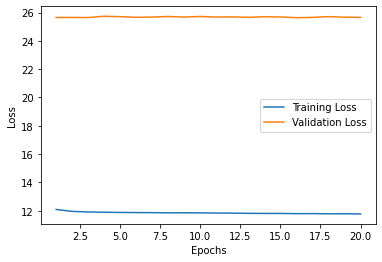

In [36]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
X_train_5.total_hours.nunique()

7780

# Building the LSTM Model

## For Window-size 5

In [22]:
LSTM_CELL_SIZE = 10
BATCH_SIZE = 1
EPOCHS = 20
DROPOUT_RATE= 0.15
LEARNING_RATE= 0.0005

In [12]:
#TIME_WINDOW = 5

In [15]:
X_train_5_norm.shape

(91512, 41)

In [ ]:
row_count = X_train_5_norm.shape[0]
column_count = X_train_5_norm.shape[1]

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.math import exp
from tensorflow.keras.callbacks import LearningRateScheduler

row_count = X_train_5_norm.shape[0]
column_count = X_train_5_norm.shape[1]

be.clear_session()


input_layer = Input(shape=(None, column_count))

lstm_layer = LSTM(LSTM_CELL_SIZE, dropout=DROPOUT_RATE)(input_layer)
#lstm_layer = LSTM(LSTM_CELL_SIZE, dropout=DROPOUT_RATE, return_sequences=True)(input_layer)
#lstm_layer_2 = LSTM(LSTM_CELL_SIZE, dropout=DROPOUT_RATE)(lstm_layer)

dense_layer = Dense(1, activation='linear')(lstm_layer)
#dense_layer = Dense(1, activation='linear')(lstm_layer_2)

# You might very well be needing it!
# Remeber to save only what is worth it from validation perspective...
# model_saver = ModelCheckpoint(...)

# If you need it...
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr*exp(-0.1)

#lr_scheduler = LearningRateScheduler(schedule)

# Build your whole LSTM model here!
model = Model(inputs=input_layer, outputs=dense_layer)

#For shape remeber, we have a variable defining the "window" and the features in the window...

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(loss='mean_squared_error', optimizer=optimizer)
# Fit on the train data
# USE the batch size parameter!
# Use validation data - warning, a tuple of stuff!
# Epochs as deemed necessary...
# You should avoid shuffling the data maybe.
# You can use the callbacks for LR schedule or model saving as seems fit.
callback = LearningRateScheduler(scheduler)
history = model.fit(x=X_train_5_norm,y=y_train_5, batch_size=BATCH_SIZE, validation_data=(X_valid_5_norm,y_valid_5), epochs=EPOCHS, callbacks=[callback], verbose=1, shuffle=False)


Epoch 1/20


ValueError: in user code:

    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\danie\miniconda3\envs\autoencoder\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:215 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer lstm is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (1, 41)
